In [1]:
import scipy
import scipy.fftpack
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
from pathlib import Path
import pickle
import timeit
import sys, os

import pycoss.rod as rod
import pycoss.rod.interp.FFT as FFT
from pycoss.rod.helpers import *
from pycoss.rod.integrators import *
import pycoss.rod.helpers.plotting as plotting

In [2]:
np.seterr(all='raise')
import warnings
warnings.filterwarnings(action="error", category=np.ComplexWarning)

## Parameters

In [3]:
sim_name = 'UD_rod_closed'
output_folder = '../output'
scenario_name = 'test_scenario'
run_name = 'test'

dt = 1e-4
integrator = 'integrator_UD_SE3'

In [4]:
L0 = 1
L = 2
dim = 3

Nm = 200
Mm = 1024
Mm_render = Nm*100
Mm_save = Nm*10

# Generate curve

random_seed = 3323
frame_rot_ampl = 3
N_random_curve_modes = 3
mu_random_curve = 0
sigma_random_curve = 0.3

# System parameters

lmbd = 1
alpha = 1

# Simulation parameters

T = 20
taylor_tol = 1e-2

# Misc

N_save = 100
N_clock = 100
N_integrator_trials = int(1e4)

In [5]:
# Load arguments if running as a script
if sys.argv[1] == "args":
    params_pkl_path = sys.argv[2]
    args_params = pickle.load(open(params_pkl_path, 'rb'))

    for param_k, param_v in args_params.items():
        globals()[param_k] = param_v

## Initial conditions

In [6]:
fft_Nm = Nm//2 + 1

us = FFT.grid(Mm, L0)
us_ext = np.linspace(0, L0, Mm+1, endpoint=True)
du = us[1] - us[0]

us_save = FFT.grid(Mm, L0)
us_save_ext = np.linspace(0, L0, Mm_save+1, endpoint=True)
du_save = us[1] - us[0]

In [7]:
path_handler = FFT.FourierHandler(dim, Nm, Mm, L0)
path_handler_render = FFT.FourierHandler(dim, Nm, Mm_render, L0)

In [8]:
frame_rot_th = np.sin(2*np.pi*path_handler_render.grid/L0) * frame_rot_ampl
frame_rot_phi = np.cos(2*np.pi*path_handler_render.grid/L0) * frame_rot_ampl
frame_rot_psi = np.sin(2*np.pi*path_handler_render.grid/L0) * frame_rot_ampl

In [9]:
if random_seed != -1:
    np.random.seed(random_seed)

In [10]:
cn_K = np.random.random((3,3))

cn_K = cn_K + cn_K.T
cn_K += np.eye(3) * 3
cn_K /= np.max(np.linalg.eigvals(cn_K))

cn_K *= 1e-2


cn_Eps = np.random.random((3,3))

cn_Eps = cn_Eps + cn_Eps.T
cn_Eps += np.eye(3) * 3
cn_Eps /= np.max(np.linalg.eigvals(cn_Eps))

cn_Eps *= 1e-3

mI = np.random.random((3,3))

mI = mI + mI.T
mI += np.eye(3) * 3
mI /= np.max(np.linalg.eigvals(mI))

mI *= 1

In [11]:
def generate_random_periodic_function(dim, us, L, N, mu, sigma):
    fs = np.zeros((3, len(us)))
    dfs = np.zeros((3, len(us)))
    
    for i in range(dim):
        fs[i] += np.random.normal(mu, sigma)/2
        
        for j in range(1, N):
            a, b= np.random.normal(mu, sigma), np.random.normal(mu, sigma)
            
            fs[i] += a * np.cos((2*np.pi/L)*j*us) / (j*np.pi)
            fs[i] += b * np.sin((2*np.pi/L)*j*us) / (j*np.pi)
            
            dfs[i] += -(a * (2*np.pi/L)*j / (j*np.pi)) * np.sin((2*np.pi/L)*j*us)
            dfs[i] += (b * (2*np.pi/L)*j / (j*np.pi)) * np.cos((2*np.pi/L)*j*us)
            
    return fs, dfs

R0_raw, dR0_raw = generate_random_periodic_function(dim, path_handler_render.grid, L0,
                                       N_random_curve_modes, mu_random_curve, sigma_random_curve)

#fig = plt.figure(figsize=(10,10))
#plot_centerline(R0_raw, fig=fig)
#plt.show()

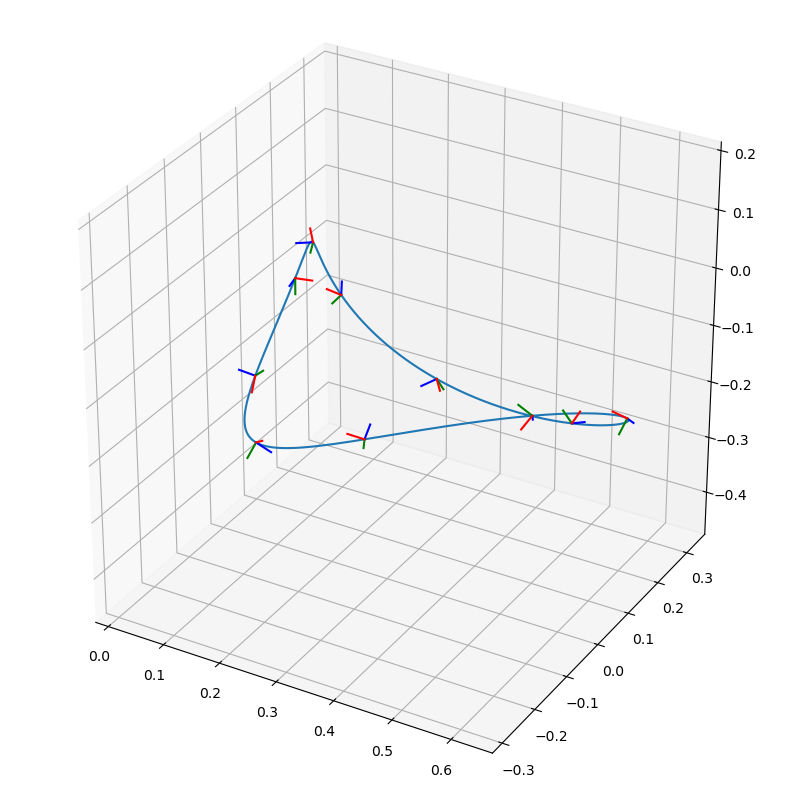

R_err: 0.00010414175733489822
close_err: 2.3281702532972075e-07


In [12]:
c_th0, c_pi0, R_u0, E_u0, R_err0, close_err0 = get_differential_invariants_from_curve(R0_raw, Nm, Mm,
                                                                    L0, L=L, err_tol=1e-1, dR=dR0_raw)

c_th0_render = path_handler.change_Mm(c_th0, Mm, Mm_render)
c_pi0_render = path_handler.change_Mm(c_pi0, Mm, Mm_render)

th0_render = path_handler_render.iDT(c_th0_render)
pi0_render = path_handler_render.iDT(c_pi0_render)

# Rotate the frame

frame_rotation = eul2rot([frame_rot_th, frame_rot_phi, frame_rot_psi])

du_frame_rotation = np.zeros(frame_rotation.shape)
for i in range(3):
    du_frame_rotation[i,:] = path_handler_render.diff_f( frame_rotation[i,:] )
    
pi0_hat_render = hat_vec_to_mat(pi0_render)

transformed_pi0_hat_render = np.einsum('iju,kju->iku', du_frame_rotation, frame_rotation)
transformed_pi0_hat_render += np.einsum('iju,jku,lku->ilu', frame_rotation, pi0_hat_render, frame_rotation)
transformed_pi0_render = hat_mat_to_vec(transformed_pi0_hat_render)

transformed_th0_render = np.einsum('iju,ju->iu', frame_rotation, th0_render)

E_u0 = E_u0.dot(frame_rotation[...,0].T)

th0_render = transformed_th0_render
pi0_render = transformed_pi0_render

# Transform back to Fourier modes

c_th0_render = path_handler_render.DT(th0_render)
c_pi0_render = path_handler_render.DT(pi0_render)

c_th0 = path_handler.change_Mm(c_th0_render, Mm_render, Mm)
c_pi0 = path_handler.change_Mm(c_pi0_render, Mm_render, Mm)

c_th0_render = path_handler.change_Mm(c_th0, Mm, Mm_render)
c_pi0_render = path_handler.change_Mm(c_pi0, Mm, Mm_render)

th0_render = path_handler_render.iDT(c_th0_render)
pi0_render = path_handler_render.iDT(c_pi0_render)

th0 = path_handler.iDT(c_th0)
pi0 = path_handler.iDT(c_pi0)

# Plot rod

Fr0_u0 = construct_oriented_frame(R_u0, E_u0)
Fr0, R0, E0 = reconstruct_frame(th0_render, hat_vec_to_mat(pi0_render), L0, R_u0, E_u0)

fig = plt.figure(figsize=(10,10))
plotting.plot_centerline_and_frame(R0, E0, fig=fig, N_frame=10, frame_scale=0.03)
plt.show()
plt.close()

print('R_err:', R_err0)
print('close_err:', close_err0)

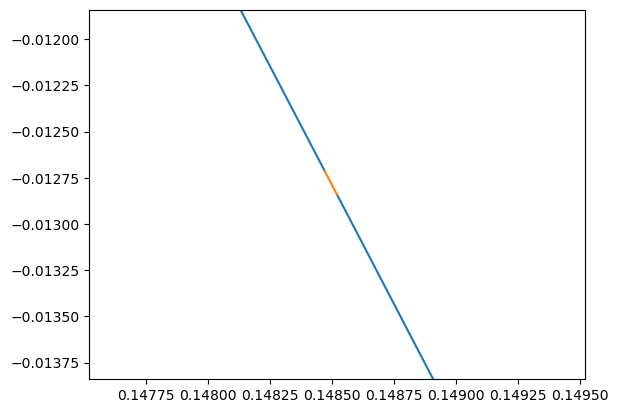

In [13]:
d = 1e-3
fig, ax = plt.subplots()
ax.plot(R0[0], R0[1])
ax.plot([R0[0,-1],R0[0,0]], [R0[1,-1],R0[1,0]])
ax.set_xlim(R0[0,-1]-d, R0[0,-1]+d)
ax.set_ylim(R0[1,-1]-d, R0[1,-1]+d)
plt.show()
plt.close()

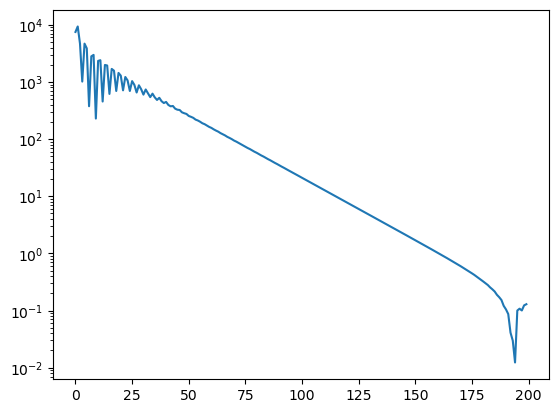

In [14]:
fig, ax = plt.subplots()
ax.plot(np.abs(c_pi0[2]))
ax.set_yscale('log')
plt.show()
plt.close()

## Define dynamics

In [15]:
th_ground = np.zeros((3,Mm))
th_ground[0] = 1

def compute_F(t, th, pi, out=None):
    F = np.einsum('ij,ju->iu', cn_K, th-th_ground, out=out)
    return F

def compute_M(t, th, pi, out=None):
    M = np.einsum('ij,ju->iu', cn_Eps, pi, out=out)
    return M

th_ext_ground = np.zeros((3,Mm+1))
th_ext_ground[0] = 1

def compute_U_T(us, th, pi):
    dth = th - th_ext_ground
    U_T = np.einsum('iu,ij,ju->u', dth, cn_K, dth)
    U_T = np.trapz(U_T, us)*0.5
    return U_T

def compute_U_R(us, th, pi):
    U_R = np.einsum('iu,ij,ju->u', pi, cn_Eps, pi)
    U_R = np.trapz(U_R, us)*0.5
    return U_R

def compute_U(us, th, pi):
    return compute_U_T(us, th, pi) + compute_U_R(us, th, pi)

def compute_K_T(us, V, Omg, mI):
    K_T = V[0]**2 + V[1]**2 + V[2]**2
    K_T = np.trapz(K_T, us)*0.5
    return K_T

def compute_K_R(us, V, Omg, mI):
    L = np.einsum('ij,ju', mI, Omg)
    K_R = vec_vec_dot(L, Omg)
    K_R = np.trapz(K_R, us)*0.5
    return K_R

def compute_K(us, h, V, Omg, mI):
    return compute_K_T(us, V, Omg, mI) + compute_K_R(us, V, Omg, mI)

In [16]:
U0 = compute_U(path_handler.grid_ext,
                      path_handler.get_ext_f(th0, c_th0),
                      path_handler.get_ext_f(pi0, c_pi0))
U_T0 = compute_U_T(path_handler.grid_ext,
                      path_handler.get_ext_f(th0, c_th0),
                      path_handler.get_ext_f(pi0, c_pi0))
U_R0 = compute_U_R(path_handler.grid_ext,
                      path_handler.get_ext_f(th0, c_th0),
                      path_handler.get_ext_f(pi0, c_pi0))

print('U:', U0)
print('U_T:', U_T0)
print('U_R:', U_R0)

U: 0.2664836717476691
U_T: 0.019510853493403826
U_R: 0.2469728182542653


## Simulate

In [17]:
params = {
    'T' : T,
    'dt' : dt,
    'taylor_tol' : taylor_tol,
    
    'alpha' : alpha,
    'lmbd' : lmbd,
    'mI' : mI,
    
    'path_handler' : path_handler,
    'path_handler_render' : path_handler_render,
    
    'c_pi0' : c_pi0,
    'c_th0' : c_th0,
    'Fr0_u0' : Fr0_u0,
    
    'F' : compute_F,
    'M' : compute_M,
    
    'U_T' : compute_U_T,
    'U_R' : compute_U_R,
    'K_T' : compute_K_T,
    'K_R' : compute_K_R,
    
    'N_save' : 100,
    'Mm_save' : Mm_save,
    
    'N_clock' : 100,
}

In [18]:
params['integrator'] = globals()[integrator]
sim_res = rod.sim.UD_simulate(params)

## Saving results

In [19]:
data_path = Path(output_folder, sim_name, scenario_name, run_name)
data_path.mkdir(parents=True, exist_ok=True)

figs_path = Path(data_path, 'figs')
figs_path.mkdir(parents=True, exist_ok=True)

In [20]:
pickle.dump(sim_res, open(Path( data_path, 'sim_res.pkl' ), 'wb'))

In [21]:
_params = dict.copy(params)

del _params['path_handler']
del _params['path_handler_render']
del _params['F']
del _params['M']
del _params['U_T']
del _params['U_R']
del _params['K_T']
del _params['K_R']
_params['integrator'] = integrator

pickle.dump(_params, open(Path( data_path, 'params.pkl' ), 'wb'))

### Stats

In [22]:
c_th = sim_res['c_th']
c_pi = sim_res['c_pi']
c_V = sim_res['c_V']
c_Omg = sim_res['c_Omg']
imI = np.linalg.inv(mI)

t = 0
dt = params['dt']
lmbd = params['lmbd']
taylor_tol = params['taylor_tol']

func = globals()[integrator]
lfunc = lambda: func(c_th, c_pi, c_V, c_Omg, t, dt, compute_F, compute_M, path_handler,
                 alpha, mI, imI, lmbd, taylor_tol, pre_transform=None, post_transform=None)
integrator_time_single_step = timeit.timeit(lfunc, number=N_integrator_trials)/N_integrator_trials
integrator_time = integrator_time_single_step * sim_res['Nt']
integrator_time /= 60**2

In [23]:
stats = {
    'integrator_time' : integrator_time,
    'integrator_time_single_step' : integrator_time_single_step,
    'sim_run_time' : sim_res['sim_run_time'],
    'sim_run_time2' : sim_res['sim_run_time2'],
    
    'U0' : U0,
    'U_T0' : U_T0,
    'U_R0' : U_R0,
    
    'Uf' : sim_res['U'][-1],
    'U_Tf' : sim_res['U_T'][-1],
    'U_Rf' : sim_res['U_R'][-1],
    
    'close_err_f' : sim_res['close_err_f'],
}

pickle.dump(stats, open(Path( data_path, 'stats.pkl' ), 'wb'))

In [24]:
with open(Path( data_path, 'stats.txt' ), 'w') as f:
    for k, v in stats.items():
        f.write('%s: %s\n' % (k,v))

### Figures

In [25]:
plt.rcParams['figure.facecolor'] = 'white'

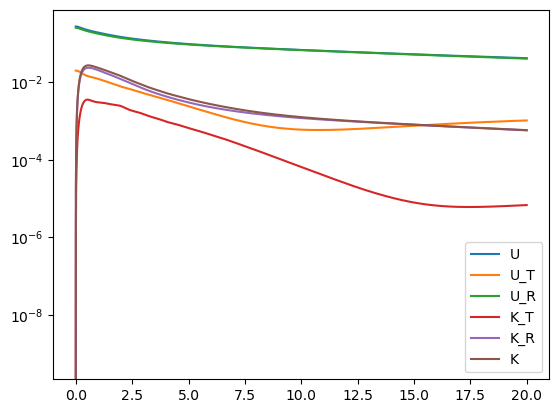

In [26]:
fig, ax = plt.subplots()

ts = np.linspace(0, T, len(sim_res['U']))

ax.plot(ts, sim_res['U'], label='U')
ax.plot(ts, sim_res['U_T'], label='U_T')
ax.plot(ts, sim_res['U_R'], label='U_R')
ax.plot(ts, sim_res['K_T'], label='K_T')
ax.plot(ts, sim_res['K_R'], label='K_R')
ax.plot(ts, sim_res['K'], label='K')
ax.set_yscale('log')

plt.legend()

fig.savefig(Path( figs_path, 'U.png' ))

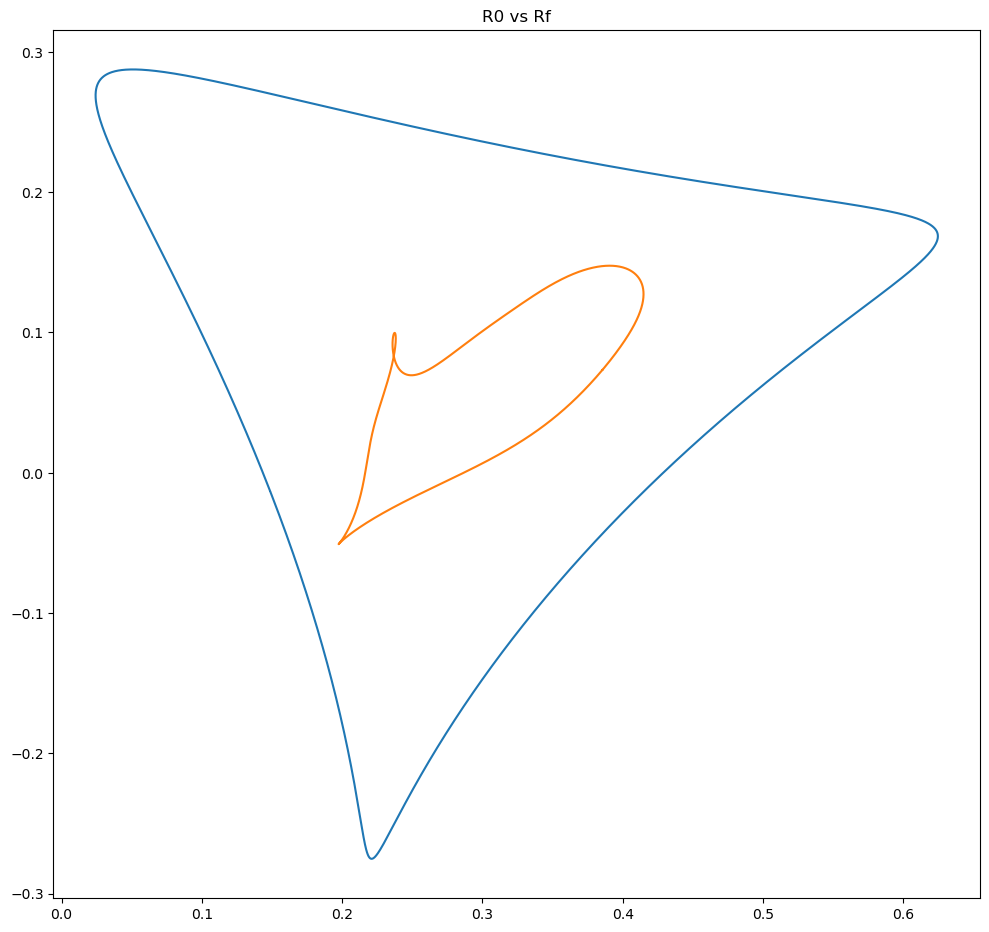

In [27]:
fig, ax = plotting.plot_centerline_2D(sim_res['saved_R'][0])
ax.set_title('R0 vs Rf')
plotting.plot_centerline_2D(sim_res['saved_R'][-1], fig=fig, ax=ax)
plt.tight_layout()
plt.show()
fig.savefig(Path( figs_path, 'R0_vs_Rf.png' ))
plt.close()

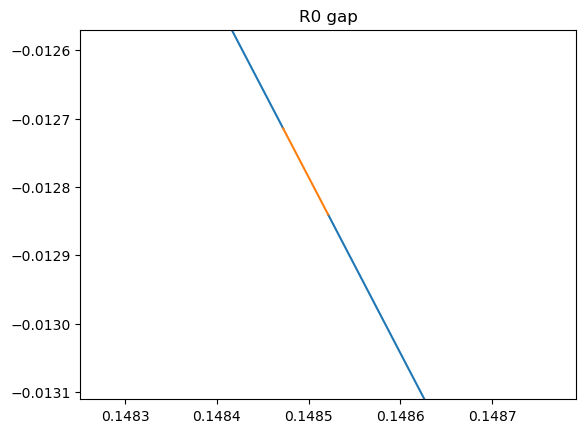

In [28]:
fig, ax = plt.subplots()
ax.set_title('R0 gap')
R = R0
d = np.linalg.norm(R[:,0] - R[:,-1])*2
ax.plot(R[0], R[1])
ax.plot([R[0,-1],R[0,0]], [R[1,-1],R[1,0]])
ax.set_xlim(R[0,-1]-d, R[0,-1]+d)
ax.set_ylim(R[1,-1]-d, R[1,-1]+d)
fig.savefig(Path( figs_path, 'R0_gap.png' ))
plt.show()
plt.close()

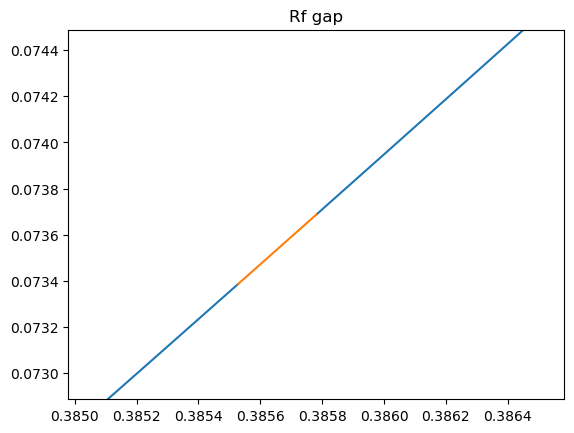

In [29]:
fig, ax = plt.subplots()
ax.set_title('Rf gap')
R = sim_res['Rf']
d = np.linalg.norm(R[:,0] - R[:,-1])*2
ax.plot(R[0], R[1])
ax.plot([R[0,-1],R[0,0]], [R[1,-1],R[1,0]])
ax.set_xlim(R[0,-1]-d, R[0,-1]+d)
ax.set_ylim(R[1,-1]-d, R[1,-1]+d)
fig.savefig(Path( figs_path, 'Rf_gap.png' ))
plt.show()
plt.close()

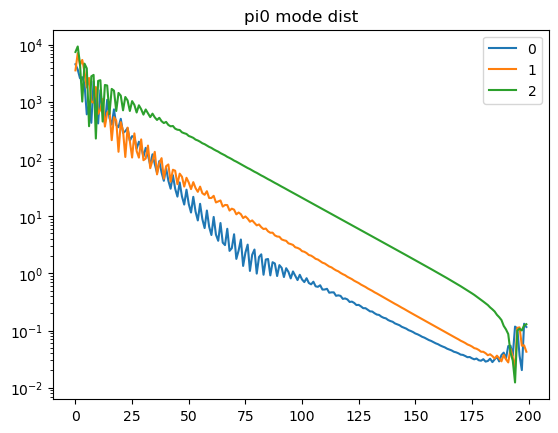

In [30]:
fig, ax = plt.subplots()
ax.set_title('pi0 mode dist')
ax.plot(np.abs(c_pi0[0]), label='0')
ax.plot(np.abs(c_pi0[1]), label='1')
ax.plot(np.abs(c_pi0[2]), label='2')
ax.set_yscale('log')
ax.legend()
fig.savefig(Path( figs_path, 'pi0_mode_dist.png' ))
plt.show()
plt.close()

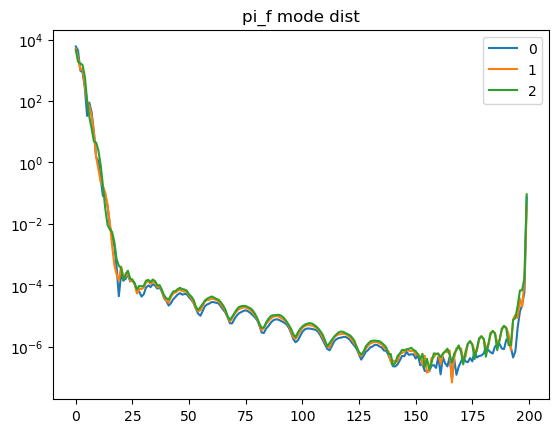

In [31]:
fig, ax = plt.subplots()
ax.set_title('pi_f mode dist')
ax.plot(np.abs(sim_res['c_pi'][0]), label='0')
ax.plot(np.abs(sim_res['c_pi'][1]), label='1')
ax.plot(np.abs(sim_res['c_pi'][2]), label='2')
ax.set_yscale('log')
ax.legend()
fig.savefig(Path( figs_path, 'pi_f_mode_dist.png' ))
plt.show()
plt.close()

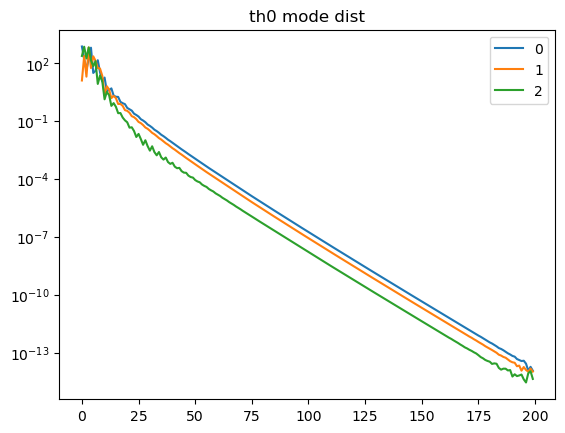

In [32]:
fig, ax = plt.subplots()
ax.set_title('th0 mode dist')
ax.plot(np.abs(c_th0[0]), label='0')
ax.plot(np.abs(c_th0[1]), label='1')
ax.plot(np.abs(c_th0[2]), label='2')
ax.set_yscale('log')
ax.legend()
fig.savefig(Path( figs_path, 'th0_mode_dist.png' ))
plt.show()
plt.close()

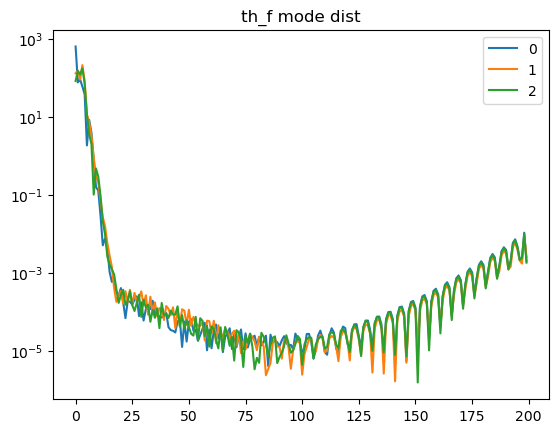

In [33]:
fig, ax = plt.subplots()
ax.set_title('th_f mode dist')
ax.plot(np.abs(sim_res['c_th'][0]), label='0')
ax.plot(np.abs(sim_res['c_th'][1]), label='1')
ax.plot(np.abs(sim_res['c_th'][2]), label='2')
ax.set_yscale('log')
ax.legend()
fig.savefig(Path( figs_path, 'th_f_mode_dist.png' ))
plt.show()
plt.close()

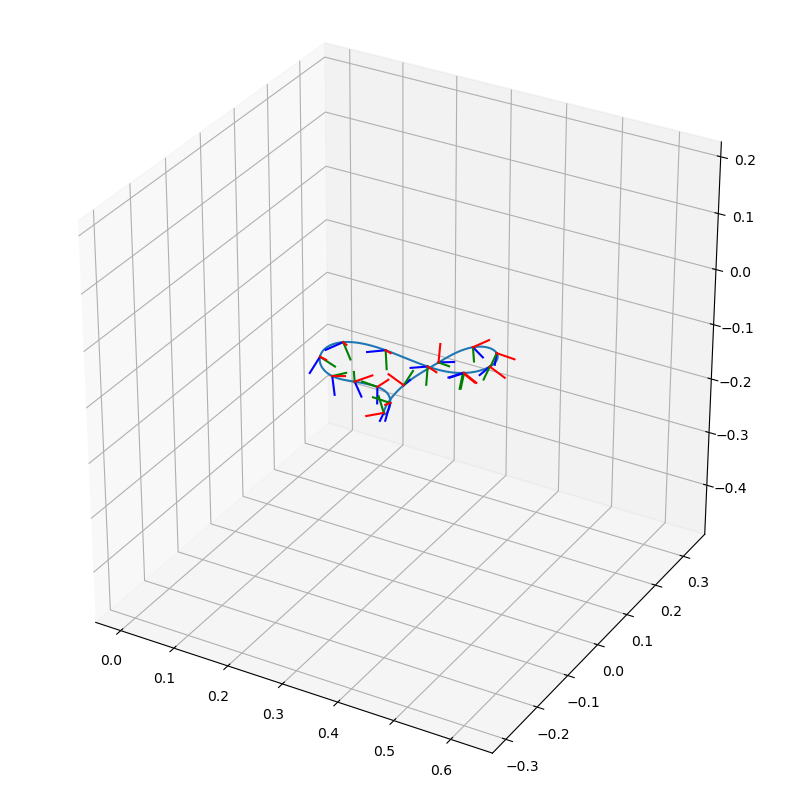

In [34]:
R = sim_res['saved_R'][0]
d = max(R[0]) - np.min(R[0])
d = max(d, np.max(R[1]) - np.min(R[1]))
d = max(d, np.max(R[2]) - np.min(R[2]))
frame_scale = d/20
N_frame = 15

plotting.vid_centerline_and_frame_3D(sim_res['saved_R'], sim_res['saved_E'],
                            save_name='%s/video.mp4' % data_path, frame_scale=frame_scale, N_frame=N_frame)
plt.show()
plt.close()